## Matrix Processing with Pandas
### 2023-10-12

This notebook details the step to process the matrix of allele frequencies for each variant in each sample. The matrix is generated from the output `bcftools` pipeline.

### Loading data into Pandas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load an example filtered matrix of footprinting scores, which overlap the variant sites in the vcf files

df_fpscore = pd.read_csv("/scratch/users/ntu/suffiazi/outputs/brca-vcf-filtered-fpscore-matrices/TFDP1_M08108_2.00_BRCA-subtype-vcf-filtered-matrix.txt", sep="\t")

# drop the column "TFBS_strand" and "TFBS_score"
df_fpscore = df_fpscore.drop(columns=["TFBS_strand", "TFBS_score"])
# rename columns in the dataframe
df_fpscore = df_fpscore.rename(columns={"TFBS_chr": "Chromosome", "TFBS_start": "Start", "TFBS_end": "End", "2GAMBDQ_Normal-like_score": "2GAMBDQ_Norm_fps"})
# for all column names that end with the string 'score', replace the string with 'fps'
df_fpscore = df_fpscore.rename(columns=lambda x: x.replace('score', 'fps') if x.endswith('score') else x)
df_fpscore.head(n=10)

,Chromosome,Start,End,98JKPD8_LumA_fps,ANAB5F7_Basal_fps,S6R691V_Her2_fps,PU24GB8_LumB_fps,2GAMBDQ_Norm_fps
0,chr1,191257,191268,0.00000,0.00000,0.00000,0.00000,0.00000
1,chr1,818021,818032,0.02966,0.04399,0.02131,0.03470,0.03443
2,chr1,818780,818791,0.02572,0.02376,0.02271,0.02814,0.03391
3,chr1,960570,960581,0.28046,0.33500,0.28495,0.27618,0.22986
4,chr1,977015,977026,1.10047,0.50514,0.71035,1.21305,1.30155
5,chr1,977047,977058,0.88179,0.40974,0.53173,0.98628,1.07101
6,chr1,977110,977121,0.13137,0.08845,0.10541,0.16812,0.15493
7,chr1,977142,977153,0.14436,0.08225,0.09233,0.17809,0.14291
8,chr1,977174,977185,0.22616,0.10631,0.13808,0.24319,0.22306
9,chr1,977206,977217,0.29710,0.15487,0.21703,0.33427,0.31093


In [3]:
# create a vcf load function for the query vcfs
def load_vcf(vcf_path):
    # load up the vcf file with indels and multiallelic sites split into separate rows
    df_vcf = pd.read_csv(vcf_path, sep="\t")
    # rename columns in the dataframe
    df_vcf = df_vcf.rename(columns={"#[1]CHROM": "Chromosome", "[2]POS": "Start", "[3]REF": "ref_allele", "[4]ALT": "alt_allele", "[5]AF": "AF"})
    # add a column next to the "start" column called "end" with the same value as the "start" column
    df_vcf.insert(2, "End", df_vcf["Start"])
    return df_vcf

# now put the paths in a list
paths = [
    "/scratch/users/ntu/suffiazi/outputs/brca-called-variants-diffmode-AF-query/ANAB5F7/ANAB5F7_TFDP1_M08108_2.00_AF-per-site-with-indels.txt",
    "/scratch/users/ntu/suffiazi/outputs/brca-called-variants-diffmode-AF-query/98JKPD8/98JKPD8_TFDP1_M08108_2.00_AF-per-site-with-indels.txt",
    "/scratch/users/ntu/suffiazi/outputs/brca-called-variants-diffmode-AF-query/PU24GB8/PU24GB8_TFDP1_M08108_2.00_AF-per-site-with-indels.txt",
    "/scratch/users/ntu/suffiazi/outputs/brca-called-variants-diffmode-AF-query/S6R691V/S6R691V_TFDP1_M08108_2.00_AF-per-site-with-indels.txt",
    "/scratch/users/ntu/suffiazi/outputs/brca-called-variants-diffmode-AF-query/2GAMBDQ/2GAMBDQ_TFDP1_M08108_2.00_AF-per-site-with-indels.txt"
]

# create a list of IDs
ids = [ "ANAB5F7_basal", "98JKPD8_lumA", "PU24GB8_lumB", "S6R691V_her2", "2GAMBDQ_norm"]

# create a pair dictionary
path_id_dict = {id: load_vcf(path) for id in ids for path in paths if id.split("_")[0] in path}

print(path_id_dict)


{'ANAB5F7_basal':      Chromosome      Start        End ref_allele   alt_allele        AF
0          chr1     818025     818025          C            A  0.812500
1          chr1     818783     818783          T            C  0.033333
2          chr1     977023     977023          G            A  0.941176
3          chr1     977055     977055          G            A  0.500000
4          chr1     977118     977118          G            A  0.852941
...         ...        ...        ...        ...          ...       ...
5979       chrX  153494830  153494830          G            A  0.352941
5980       chrX  153495413  153495413          G            A  0.882353
5981       chrX  154444635  154444635    GGGACGG  GGGACGGACGG  0.058824
5982       chrY   11108021   11108021          C            T  0.382353
5983       chrY   11108024   11108024          C            T  0.294118

[5984 rows x 6 columns], '98JKPD8_lumA':      Chromosome      Start        End ref_allele   alt_allele        AF
0   

### Converting Dataframes into Pyranges Objects with PyRanges

In [4]:
import pyranges as pr

gr_fpscore = pr.PyRanges(df_fpscore)
print(type(gr_fpscore))
gr_fpscore

<class 'pyranges.pyranges_main.PyRanges'>


,Chromosome,Start,End,98JKPD8_LumA_fps,ANAB5F7_Basal_fps,S6R691V_Her2_fps,PU24GB8_LumB_fps,2GAMBDQ_Norm_fps
0,chr1,191257,191268,0.00000,0.00000,0.00000,0.00000,0.00000
1,chr1,818021,818032,0.02966,0.04399,0.02131,0.03470,0.03443
2,chr1,818780,818791,0.02572,0.02376,0.02271,0.02814,0.03391
3,chr1,960570,960581,0.28046,0.33500,0.28495,0.27618,0.22986
4,chr1,977015,977026,1.10047,0.50514,0.71035,1.21305,1.30155
...,...,...,...,...,...,...,...,...
9555,chrX,153934861,153934872,0.19670,0.16790,0.17212,0.19046,0.16161
9556,chrX,154444629,154444640,0.04900,0.07431,0.07307,0.09013,0.04233
9557,chrX,155010397,155010408,0.01177,0.00497,0.00875,0.01298,0.01987
9558,chrX,155641610,155641621,0.01249,0.01243,0.01329,0.01492,0.01740


In [17]:
# delete a variable from current namespace
%reset_selective -f pathstring


In [5]:
# load up vcf dfs into pyranges 
grs = {}
for name,vcf in path_id_dict.items():
    gr_vcf = pr.PyRanges(vcf)
    grs[name] = gr_vcf

print(grs)


{'ANAB5F7_basal': +--------------+-----------+-----------+--------------+-------+
| Chromosome   | Start     | End       | ref_allele   | +2    |
| (category)   | (int64)   | (int64)   | (object)     | ...   |
|--------------+-----------+-----------+--------------+-------|
| chr1         | 818025    | 818025    | C            | ...   |
| chr1         | 818783    | 818783    | T            | ...   |
| chr1         | 977023    | 977023    | G            | ...   |
| chr1         | 977055    | 977055    | G            | ...   |
| ...          | ...       | ...       | ...          | ...   |
| chrX         | 154444635 | 154444635 | GGGACGG      | ...   |
| chrX         | 153495413 | 153495413 | G            | ...   |
| chrX         | 153494830 | 153494830 | G            | ...   |
| chrX         | 150364545 | 150364545 | C            | ...   |
| chrY         | 11108024  | 11108024  | C            | ...   |
| chrY         | 11108021  | 11108021  | C            | ...   |
+--------------+------

### Exploratory Plots with Seaborn

In [ ]:
count = 0
for key, val in grs.items():
    
    if count == 0:
        overlap = gr_fpscore.join(val, how='left', suffix=f"_{key}_varsite_pos", preserve_order = True)
    else:
        overlap = overlap.join(val, how='left', suffix=f"_{key}_varsite_pos", preserve_order = True)
    
    # drop the column "End" column
    overlap = overlap.drop([f"End_{key}_varsite_pos"])

    # cast back into a dataframe and rename metadata columns
    df = overlap.df.rename(columns={f"Start_{key}_varsite_pos": f"{key}_varsite_pos", "ref_allele": f"{key}_ref_allele", "alt_allele": f"{key}_alt_allele", "AF": f"{key}_AF"})
    
    # replace all the -1 values in column 'Start_varsites', 'ref_allele' and 'alt_allele', and AF with 0
    # Define a dictionary mapping column names to values to replace
    replace_dict = {f"{key}_varsite_pos": {-1: None}, f"{key}_ref_allele": {str(-1): None}, f"{key}_alt_allele": {str(-1): None}, f"{key}_AF": {-1: 0}}
    df = df.replace(replace_dict)

    # cast back into pyrange object
    overlap = pr.PyRanges(df)

    # increment count
    count += 1

# save to file
# overlap.df.to_csv("TFDP1_M08108_2.00_fpscore-af-varsites-combined-matrix.tsv", sep="\t", index=False, na_rep='NULL')

overlap.df[19:30]

The chr regions are somehow not unique anymore because each region can be associated with multiple alleles and these are written onto new lines. To reduce the chr regions to unique sites and collapse the rows into unique regions, what we can do is to assign only the allelic site that has the largest AF value out of the rest mapped to the same region (using `max()` method).

First, write a test script to see if the logic works. 

In [ ]:
test_overlap = gr_fpscore.join(grs['ANAB5F7_basal'], how='left', suffix="_ANAB5F7_basal_varsite_pos", preserve_order = True)

# drop END column
test_overlap = test_overlap.drop(["End_ANAB5F7_basal_varsite_pos"])
# cluster the pyRanges object by genomic range
test_overlap = test_overlap.cluster(slack=-1)
# filter the pandas df representation of the pyRanges object by the AF column max value for each cluster/group
filtered_df = test_overlap.df.loc[test_overlap.df.groupby('Cluster')['AF'].idxmax()]
# then rename the columns 
filtered_df = filtered_df.rename(columns={"Start_ANAB5F7_basal_varsite_pos": "ANAB5F7_basal_varsite_pos", "ref_allele": "ANAB5F7_basal_ref_allele", "alt_allele": "ANAB5F7_basal_alt_allele", "AF": "ANAB5F7_basal_AF"})
# replace all the -1 values in column 'Start_varsites', 'ref_allele' and 'alt_allele', and AF with 0
# Define a dictionary mapping column names to values to replace
replace_dict = {"ANAB5F7_basal_varsite_pos": {-1: None}, "ANAB5F7_basal_ref_allele": {str(-1): None}, "ANAB5F7_basal_alt_allele": {str(-1): None}, "ANAB5F7_basal_AF": {-1: 0}}
filtered_df = filtered_df.replace(replace_dict)
# drop cluster column
filtered_df = filtered_df.drop(columns=["Cluster"])

filtered_gr = pr.PyRanges(filtered_df)

test_overlap = filtered_gr.join(grs['2GAMBDQ_norm'], how='left', suffix="_2GAMBDQ_norm_varsite_pos", preserve_order = True)
# drop END column
test_overlap = test_overlap.drop(["End_2GAMBDQ_norm_varsite_pos"])
# cluster the pyRanges object by genomic range
test_overlap = test_overlap.cluster(slack=-1)
# filter the pandas df representation of the pyRanges object by the AF column max value for each cluster/group
filtered_df = test_overlap.df.loc[test_overlap.df.groupby('Cluster')['AF'].idxmax()]
# then rename the columns 
filtered_df = filtered_df.rename(columns={"Start_2GAMBDQ_norm_varsite_pos": "2GAMBDQ_norm_varsite_pos", "ref_allele": "2GAMBDQ_norm_ref_allele", "alt_allele": "2GAMBDQ_norm_alt_allele", "AF": "2GAMBDQ_norm_AF"})
# replace all the -1 values in column 'Start_varsites', 'ref_allele' and 'alt_allele', and AF with 0
# Define a dictionary mapping column names to values to replace
replace_dict = {"2GAMBDQ_norm_varsite_pos": {-1: None}, "2GAMBDQ_norm_ref_allele": {str(-1): None}, "2GAMBDQ_norm_alt_allele": {str(-1): None}, "2GAMBDQ_norm_AF": {-1: 0}}
filtered_df = filtered_df.replace(replace_dict)
# drop cluster column
filtered_df = filtered_df.drop(columns=["Cluster"])
filtered_df.iloc[19:30]
# filtered_df.shape

# # merge back the af_max series with the original dataframe
# result_df = test_overlap.df.merge(af_max, left_on='Cluster', right_index=True, suffixes=('', '_max'))
# result_df.head(n=30)

Then, incorporate a `for` loop to process and merge all of the subtype data. 

In [6]:
pd.set_option('display.max_columns', 999)


In [7]:
count = 0
for key, val in grs.items():  
    if count == 0:
        overlap = gr_fpscore.join(val, how='left', suffix=f"_{key}_varsite_pos", preserve_order = True)
    else:
        overlap = filtered_gr.join(val, how='left', suffix=f"_{key}_varsite_pos", preserve_order = True)
    
    # drop the column "End" column
    overlap = overlap.drop([f"End_{key}_varsite_pos"])

    # cluster the pyRanges object by genomic range
    overlap = overlap.cluster(slack=-1)

    # cast back into a dataframe and filter by the AF column's max value (per cluster); this returns a filtered dataframe
    filtered_df = overlap.df.loc[overlap.df.groupby('Cluster')['AF'].idxmax()]

    # then rename the columns
    filtered_df = filtered_df.rename(columns={f"Start_{key}_varsite_pos": f"{key}_varsite_pos", "ref_allele": f"{key}_ref_allele", "alt_allele": f"{key}_alt_allele", "AF": f"{key}_AF"})
    
    # replace all the -1 values in column 'Start_varsites', 'ref_allele' and 'alt_allele', and AF with 0
    # Define a dictionary mapping column names to values to replace
    replace_dict = {f"{key}_varsite_pos": {-1: None}, f"{key}_ref_allele": {str(-1): None}, f"{key}_alt_allele": {str(-1): None}, f"{key}_AF": {-1: 0}}
    filtered_df = filtered_df.replace(replace_dict)

    # drop cluster column
    filtered_df = filtered_df.drop(columns=["Cluster"])

    # cast back into pyrange object
    filtered_gr = pr.PyRanges(filtered_df)

    # increment count
    count += 1

final_df = filtered_gr.df

# create a column called 'region_id'
final_df["region_id"] = final_df["Chromosome"].astype(str) + ":" + final_df["Start"].astype(str) + "-" + final_df["End"].astype(str)

# save to file
final_df.to_csv("TFDP1_M08108_2.00_fpscore-af-varsites-combined-matrix-reduced.tsv", sep="\t", index=False, na_rep='NULL')

# filtered_gr.df.shape
final_df.iloc[19:30]

,Chromosome,Start,End,98JKPD8_LumA_fps,ANAB5F7_Basal_fps,S6R691V_Her2_fps,PU24GB8_LumB_fps,2GAMBDQ_Norm_fps,ANAB5F7_basal_varsite_pos,ANAB5F7_basal_ref_allele,ANAB5F7_basal_alt_allele,ANAB5F7_basal_AF,98JKPD8_lumA_varsite_pos,98JKPD8_lumA_ref_allele,98JKPD8_lumA_alt_allele,98JKPD8_lumA_AF,PU24GB8_lumB_varsite_pos,PU24GB8_lumB_ref_allele,PU24GB8_lumB_alt_allele,PU24GB8_lumB_AF,S6R691V_her2_varsite_pos,S6R691V_her2_ref_allele,S6R691V_her2_alt_allele,S6R691V_her2_AF,2GAMBDQ_norm_varsite_pos,2GAMBDQ_norm_ref_allele,2GAMBDQ_norm_alt_allele,2GAMBDQ_norm_AF,region_id
19,chr1,977682,977693,0.13628,0.06780,0.07093,0.09131,0.10189,None,None,None,0.000000,None,None,None,0.000000,977690,G,A,0.722222,None,None,None,0.000000,None,None,None,0.000000,chr1:977682-977693
20,chr1,986626,986637,0.06207,0.01957,0.02828,0.05148,0.04807,986629,G,A,0.156250,986629,G,A,0.166667,986629,G,A,0.176471,986629,G,A,0.264706,986629,G,A,0.142857,chr1:986626-986637
21,chr1,996339,996350,0.08072,0.04823,0.06484,0.05456,0.06911,None,None,None,0.000000,None,None,None,0.000000,None,None,None,0.000000,None,None,None,0.000000,None,None,None,0.000000,chr1:996339-996350
22,chr1,998799,998810,0.18224,0.18346,0.16911,0.19714,0.13315,None,None,None,0.000000,998800,C,G,0.041667,998800,C,G,0.026316,None,None,None,0.000000,None,None,None,0.000000,chr1:998799-998810
23,chr1,999627,999638,0.22751,0.11144,0.14534,0.19250,0.13830,None,None,None,0.000000,None,None,None,0.000000,None,None,None,0.000000,None,None,None,0.000000,999637,G,A,0.062500,chr1:999627-999638
24,chr1,1001633,1001644,0.14990,0.09145,0.08237,0.11098,0.10277,1001634,A,T,0.029412,None,None,None,0.000000,None,None,None,0.000000,None,None,None,0.000000,None,None,None,0.000000,chr1:1001633-1001644
25,chr1,1019832,1019843,0.52715,0.39803,0.37521,0.52936,0.43562,1019833,T,C,1.000000,1019833,T,C,1.000000,1019833,T,C,1.000000,1019833,T,C,1.000000,1019833,T,C,1.000000,chr1:1019832-1019843
26,chr1,1020018,1020029,0.60906,0.52767,0.50946,0.64164,0.49198,None,None,None,0.000000,1020021,G,T,0.041667,None,None,None,0.000000,None,None,None,0.000000,None,None,None,0.000000,chr1:1020018-1020029
27,chr1,1020936,1020947,0.30508,0.21614,0.20883,0.26597,0.23615,None,None,None,0.000000,None,None,None,0.000000,None,None,None,0.000000,None,None,None,0.000000,None,None,None,0.000000,chr1:1020936-1020947
28,chr1,1041174,1041185,0.06104,0.05750,0.05748,0.08209,0.04792,1041178,C,G,0.031250,None,None,None,0.000000,None,None,None,0.000000,None,None,None,0.000000,None,None,None,0.000000,chr1:1041174-1041185


In [8]:
final_df.shape

(9560, 29)

#### Plotting

Let's subset the filtered gr object into a dataframe.

In [9]:
import seaborn as sns
import numpy as np

In [23]:
# subset the dataframe to gget just the _AF columns
af_df = filtered_gr.df.filter(regex='_AF$')
af_df

,ANAB5F7_basal_AF,98JKPD8_lumA_AF,PU24GB8_lumB_AF,S6R691V_her2_AF,2GAMBDQ_norm_AF
0,0.000000,0.000000,0.026316,0.000000,0.000000
1,0.812500,0.900000,0.833333,0.900000,0.875000
2,0.033333,0.125000,0.055556,0.062500,0.000000
3,0.000000,0.041667,0.000000,0.000000,0.000000
4,0.941176,1.000000,0.947368,0.911765,1.000000
...,...,...,...,...,...
9555,0.000000,0.000000,0.000000,0.000000,0.062500
9556,0.058824,0.125000,0.105263,0.000000,0.000000
9557,0.000000,0.312500,0.392857,0.100000,0.083333
9558,0.000000,0.000000,0.029412,0.000000,0.000000


In [27]:
# see summary statistics
af_df.describe()

,ANAB5F7_basal_AF,98JKPD8_lumA_AF,PU24GB8_lumB_AF,S6R691V_her2_AF,2GAMBDQ_norm_AF
count,9560.000000,9560.000000,9560.000000,9560.000000,9560.000000
mean,0.124445,0.124244,0.123915,0.125958,0.125726
std,0.225746,0.234125,0.228397,0.228968,0.238772
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.029412,0.000000,0.026316,0.029412,0.000000
75%,0.133333,0.125000,0.131579,0.142857,0.125000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
# this is actually in a wide format, so we need to melt it into a long format
af_df_long = af_df.melt(var_name="sample_id", value_name="AF")
# remove the "_AF" suffix from the "sample_id" column
af_df_long["sample_id"] = af_df_long["sample_id"].apply(lambda x: x.replace("_AF", ""))
af_df_long

,sample_id,AF
0,ANAB5F7_basal,0.000000
1,ANAB5F7_basal,0.812500
2,ANAB5F7_basal,0.033333
3,ANAB5F7_basal,0.000000
4,ANAB5F7_basal,0.941176
...,...,...
47795,2GAMBDQ_norm,0.062500
47796,2GAMBDQ_norm,0.000000
47797,2GAMBDQ_norm,0.083333
47798,2GAMBDQ_norm,0.000000


In [12]:
af_df[af_df != 0].describe()

,ANAB5F7_basal_AF,98JKPD8_lumA_AF,PU24GB8_lumB_AF,S6R691V_her2_AF,2GAMBDQ_norm_AF
count,5031.000000,4135.000000,4904.000000,4824.000000,3702.000000
mean,0.236473,0.287249,0.241563,0.249619,0.324674
std,0.265235,0.282688,0.270697,0.270245,0.287473
min,0.029412,0.041667,0.026316,0.029412,0.062500
25%,0.035714,0.062500,0.033333,0.035714,0.071429
50%,0.117647,0.166667,0.131579,0.133333,0.214286
75%,0.328431,0.409091,0.342105,0.352941,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
af_df[af_df == 0].describe()

,ANAB5F7_basal_AF,98JKPD8_lumA_AF,PU24GB8_lumB_AF,S6R691V_her2_AF,2GAMBDQ_norm_AF
count,4529.0,5425.0,4656.0,4736.0,5858.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


In [17]:
penguins = sns.load_dataset("penguins")
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [15]:
# plot frequency distribution of AF values
sns.set_style("white")


AttributeError: module 'seaborn' has no attribute 'freqplot'

Text(0.5, 1.0, 'Distribution of Differential Footprint Scores across Called Variants in TFDP1_M08108_2.00 TFBS')

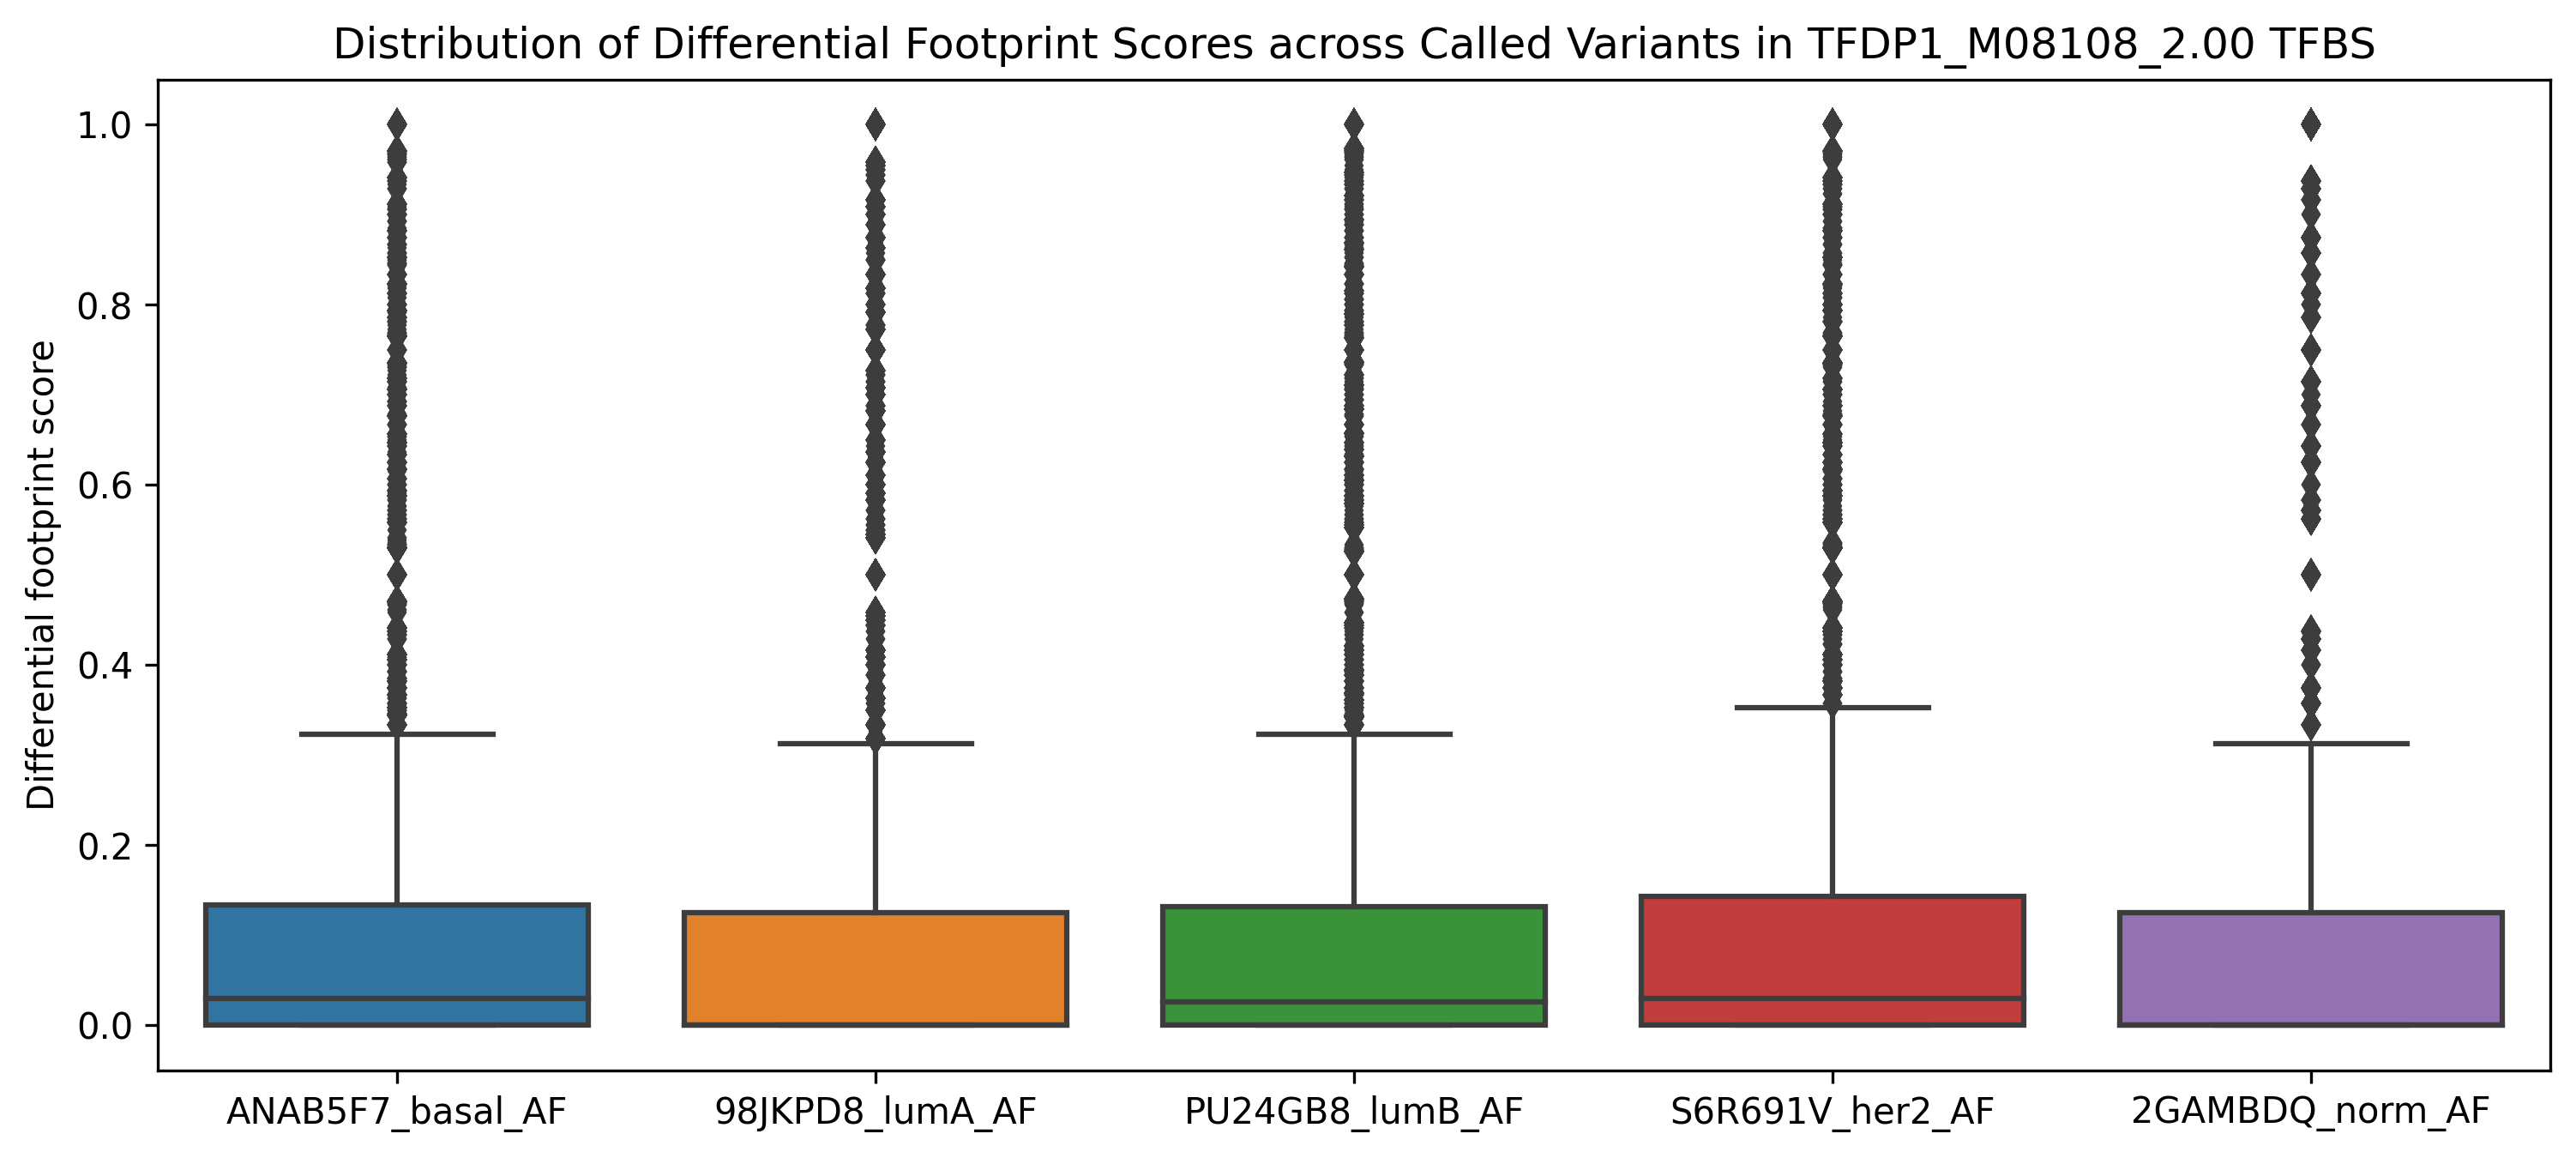

In [15]:
# the quartilelook at the distribution in a boxplot

plt.figure(figsize=(12,5), dpi=300)
sns.boxplot(data=af_df)

# add labels and title
plt.ylabel('Differential footprint score')
plt.title('Distribution of Differential Footprint Scores across Called Variants in TFDP1_M08108_2.00 TFBS')


In [25]:
af_df[af_df != 0].describe()


,ANAB5F7_basal_AF,98JKPD8_lumA_AF,PU24GB8_lumB_AF,S6R691V_her2_AF,2GAMBDQ_norm_AF
count,5031.000000,4135.000000,4904.000000,4824.000000,3702.000000
mean,0.236473,0.287249,0.241563,0.249619,0.324674
std,0.265235,0.282688,0.270697,0.270245,0.287473
min,0.029412,0.041667,0.026316,0.029412,0.062500
25%,0.035714,0.062500,0.033333,0.035714,0.071429
50%,0.117647,0.166667,0.131579,0.133333,0.214286
75%,0.328431,0.409091,0.342105,0.352941,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [98]:
# half the binding sites are actually zero AF so to focus on nonzero AF, filter out zero values
af_df_nonzero = af_df[af_df != 0]
af_df_nonzero

,ANAB5F7_basal_AF,98JKPD8_lumA_AF,PU24GB8_lumB_AF,S6R691V_her2_AF,2GAMBDQ_norm_AF
0,NaN,NaN,0.026316,NaN,NaN
1,0.812500,0.900000,0.833333,0.900000,0.875000
2,0.033333,0.125000,0.055556,0.062500,NaN
3,NaN,0.041667,NaN,NaN,NaN
4,0.941176,1.000000,0.947368,0.911765,1.000000
...,...,...,...,...,...
9555,NaN,NaN,NaN,NaN,0.062500
9556,0.058824,0.125000,0.105263,NaN,NaN
9557,NaN,0.312500,0.392857,0.100000,0.083333
9558,NaN,NaN,0.029412,NaN,NaN


Text(0.5, 1.0, 'Distribution of Differential Footprint Scores across Called Variants in TFDP1_M08108_2.00 TFBS')

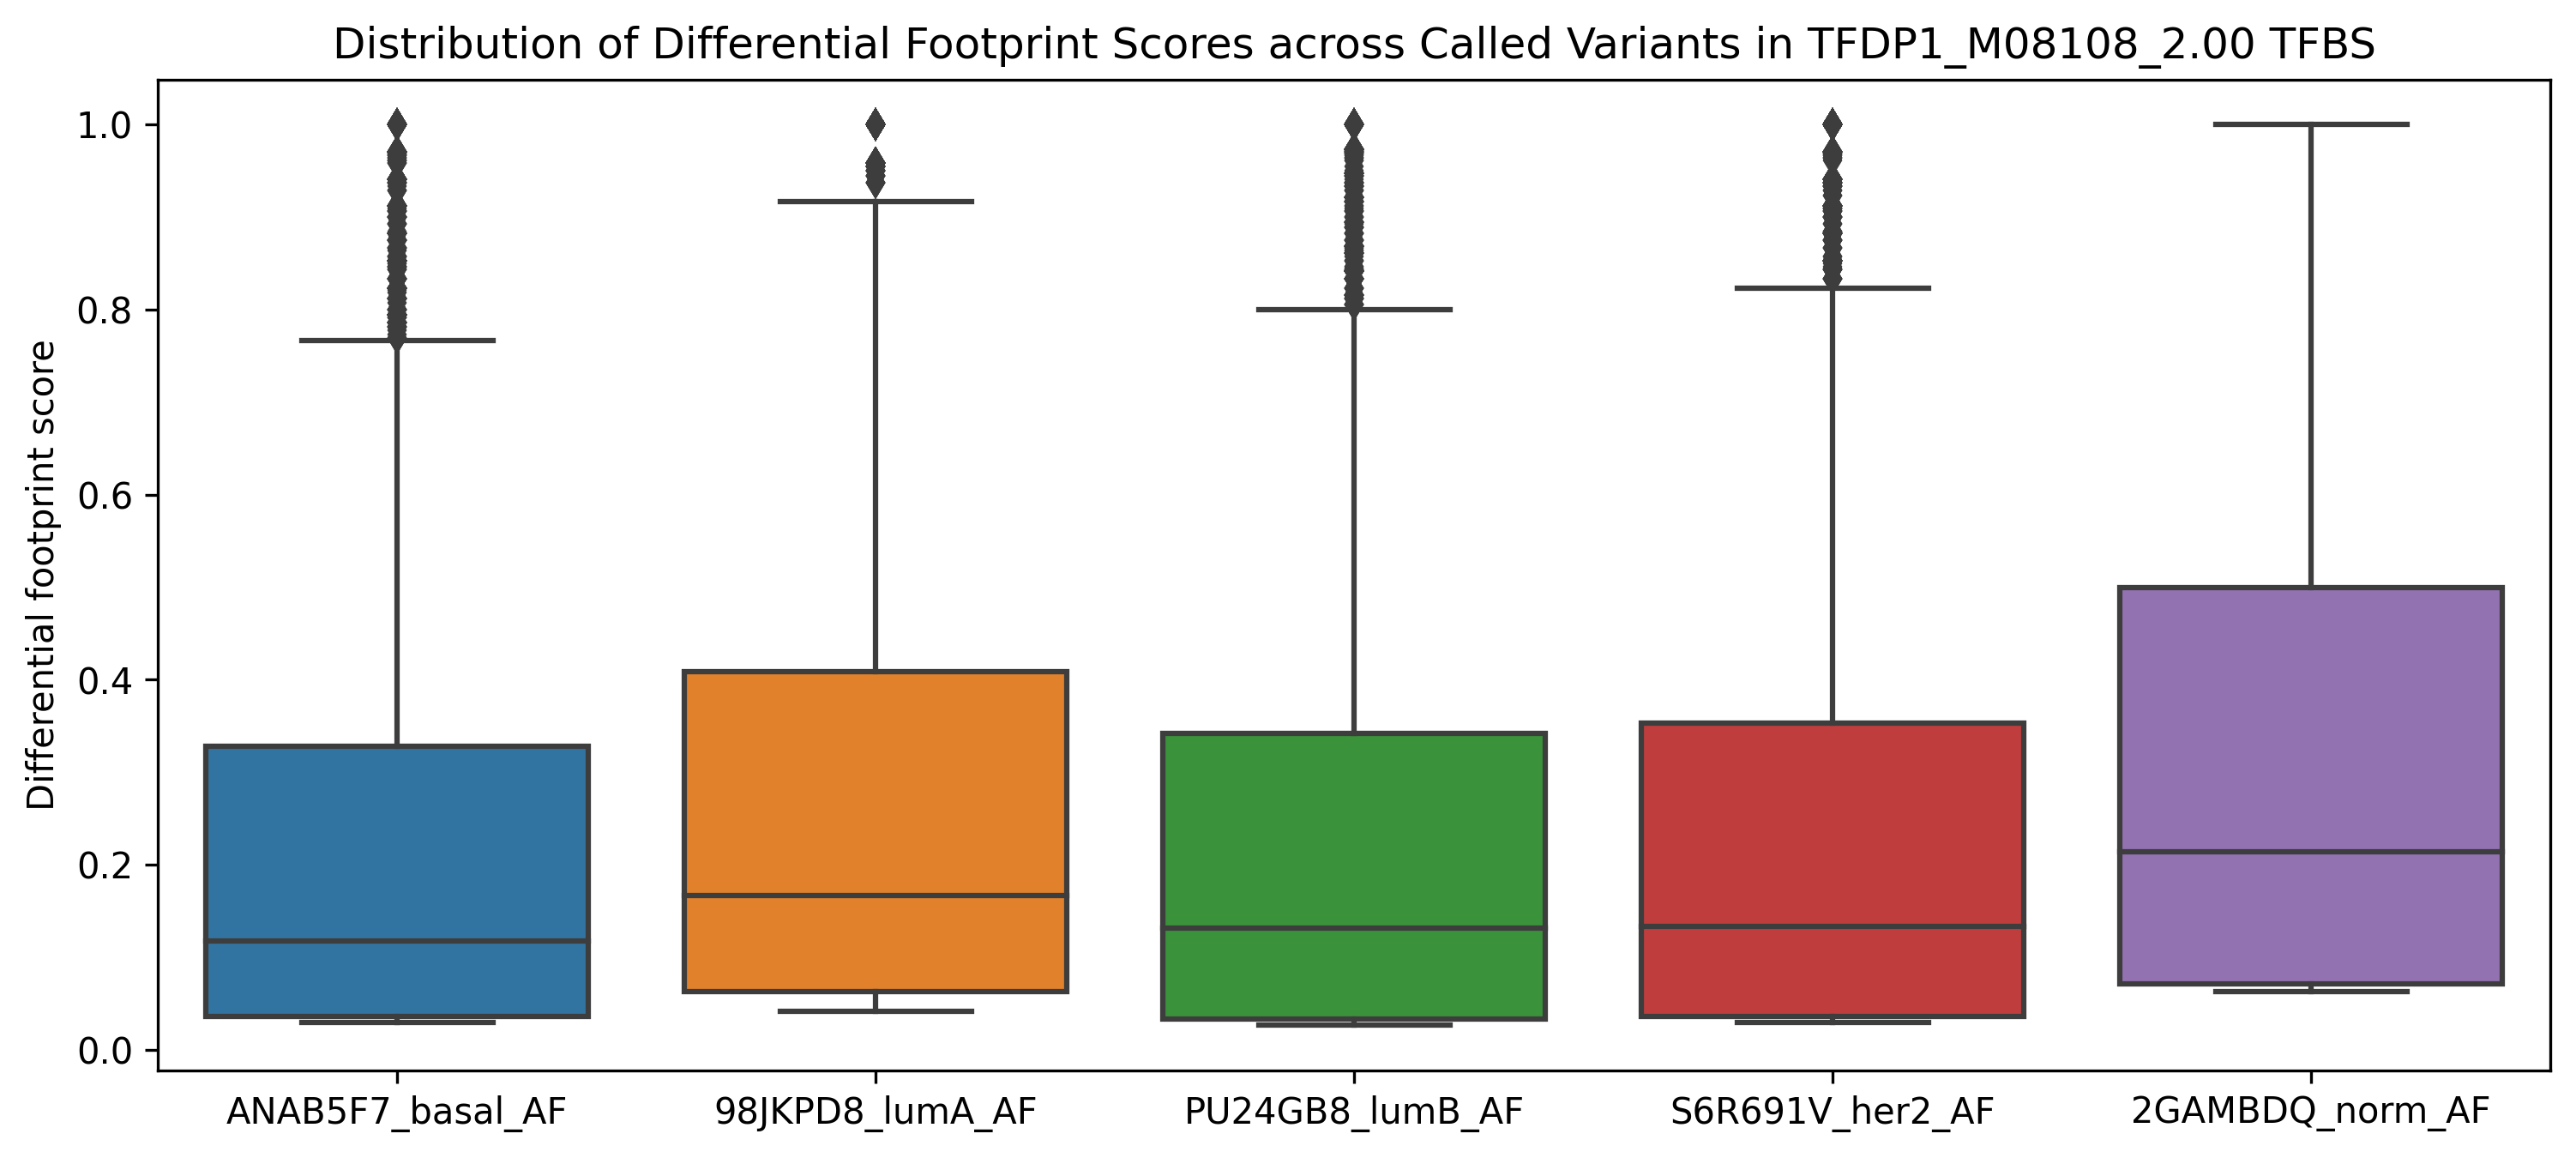

In [77]:
# look at the distribution in a boxplot

plt.figure(figsize=(12,5), dpi=300)
sns.boxplot(data=af_df_nonzero)

# add labels and title
plt.ylabel('Differential footprint score')
plt.title('Distribution of Differential Footprint Scores across Called Variants in TFDP1_M08108_2.00 TFBS')

Text(0.5, 1.0, 'Distribution of Differential Footprint Scores across Called Variants in TFDP1_M08108_2.00 TFBS')

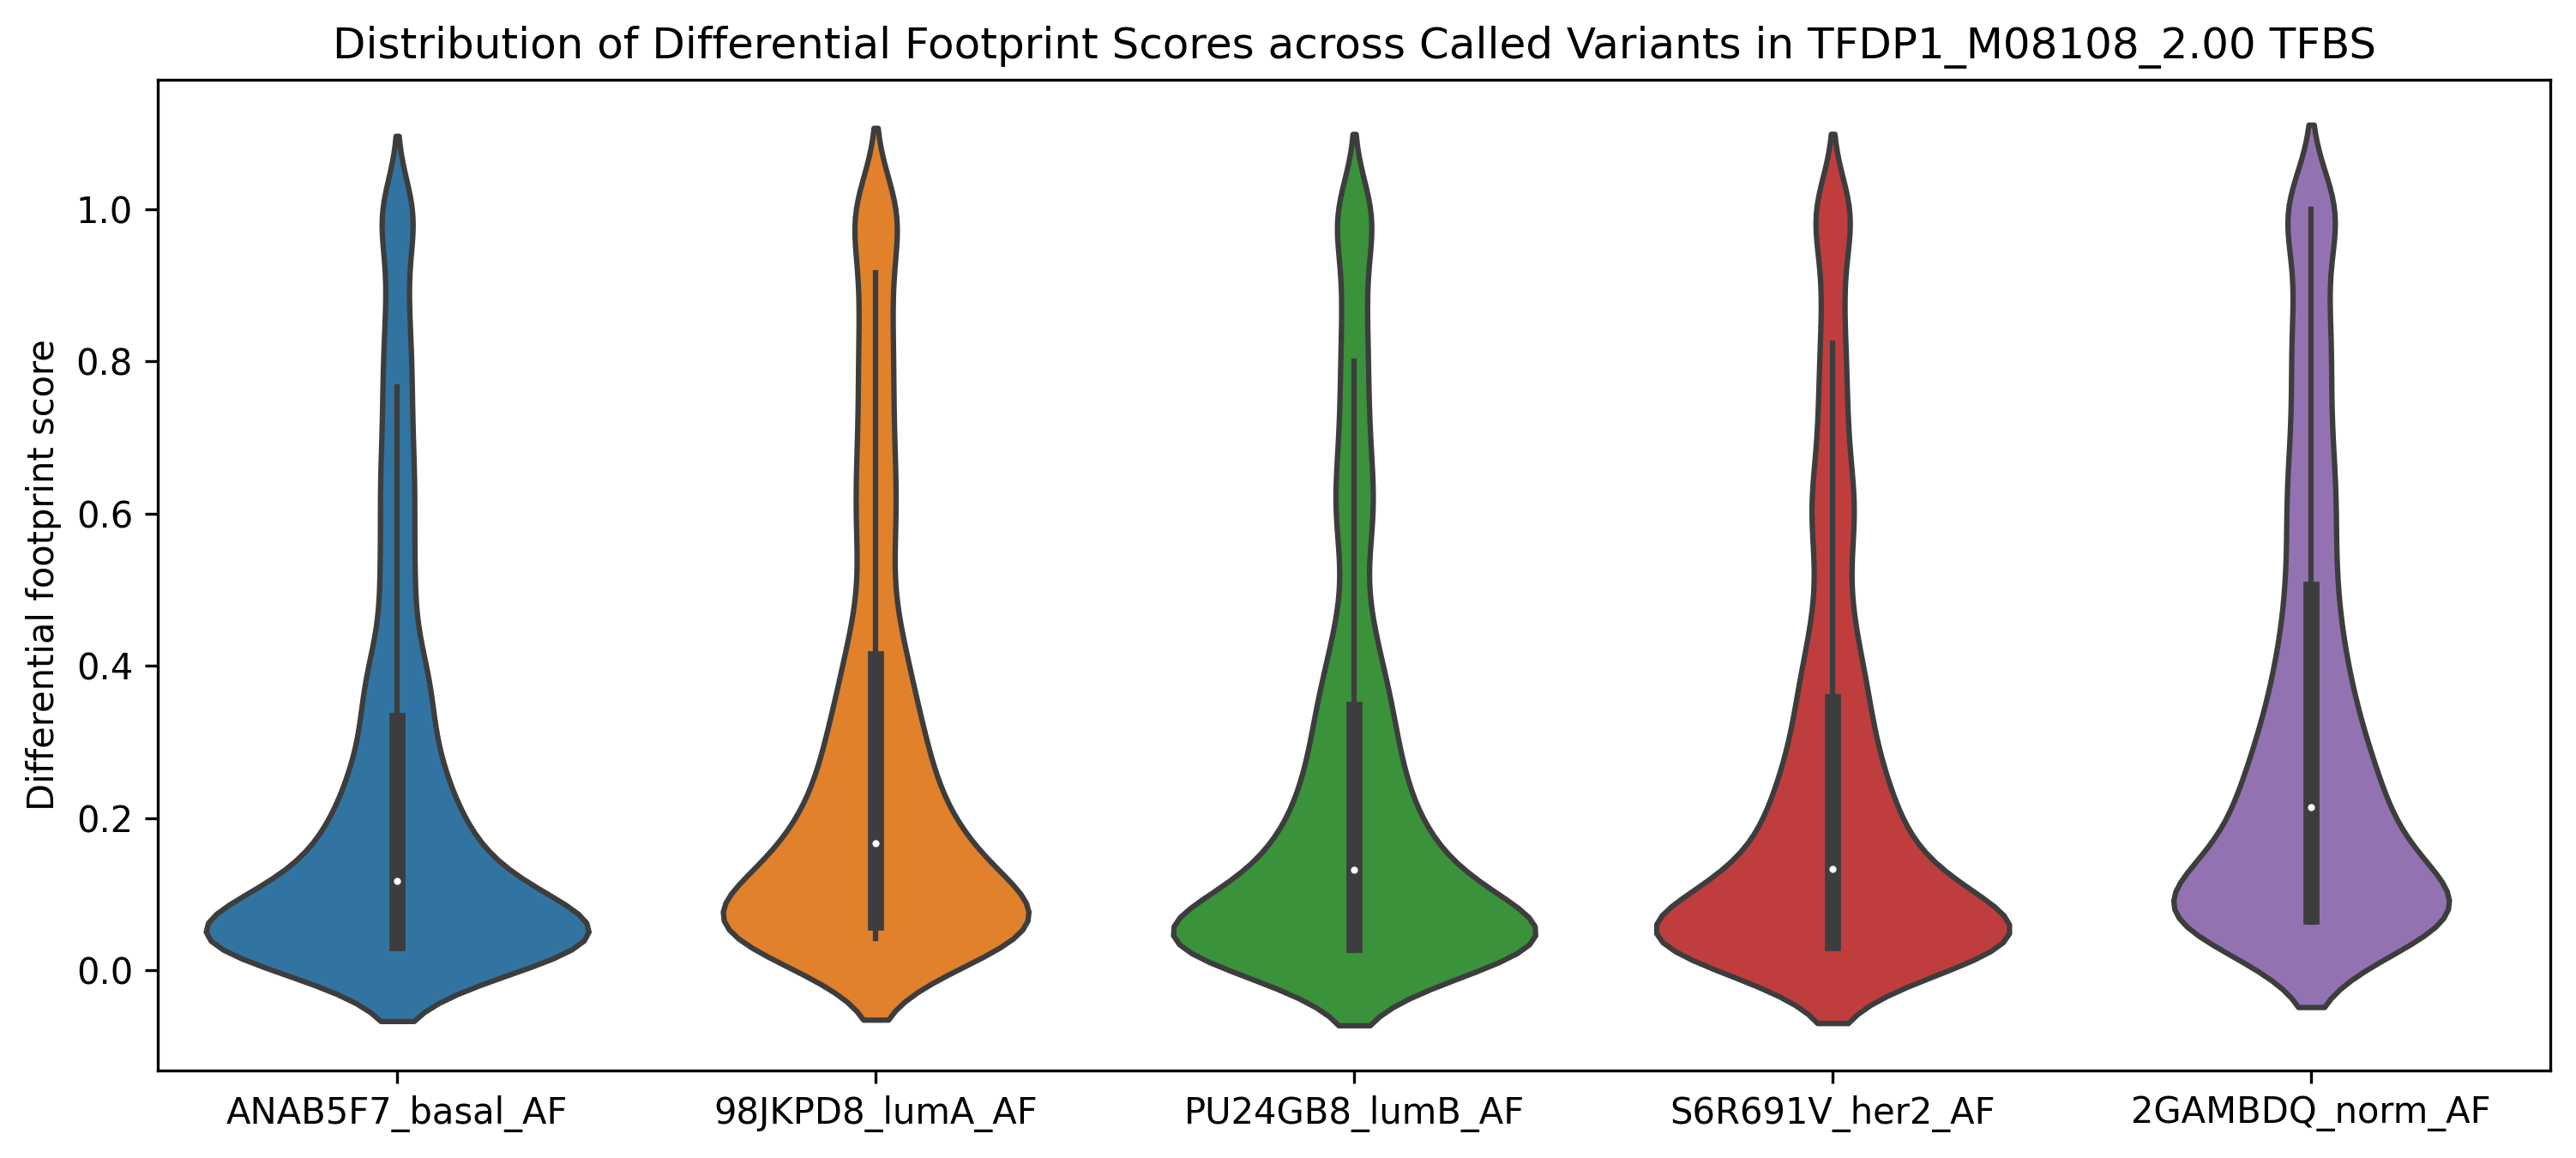

In [78]:
# look at the distribution in a boxplot

plt.figure(figsize=(12,5), dpi=300)
sns.violinplot(data=af_df_nonzero)

# add labels and title
plt.ylabel('Differential footprint score')
plt.title('Distribution of Differential Footprint Scores across Called Variants in TFDP1_M08108_2.00 TFBS')

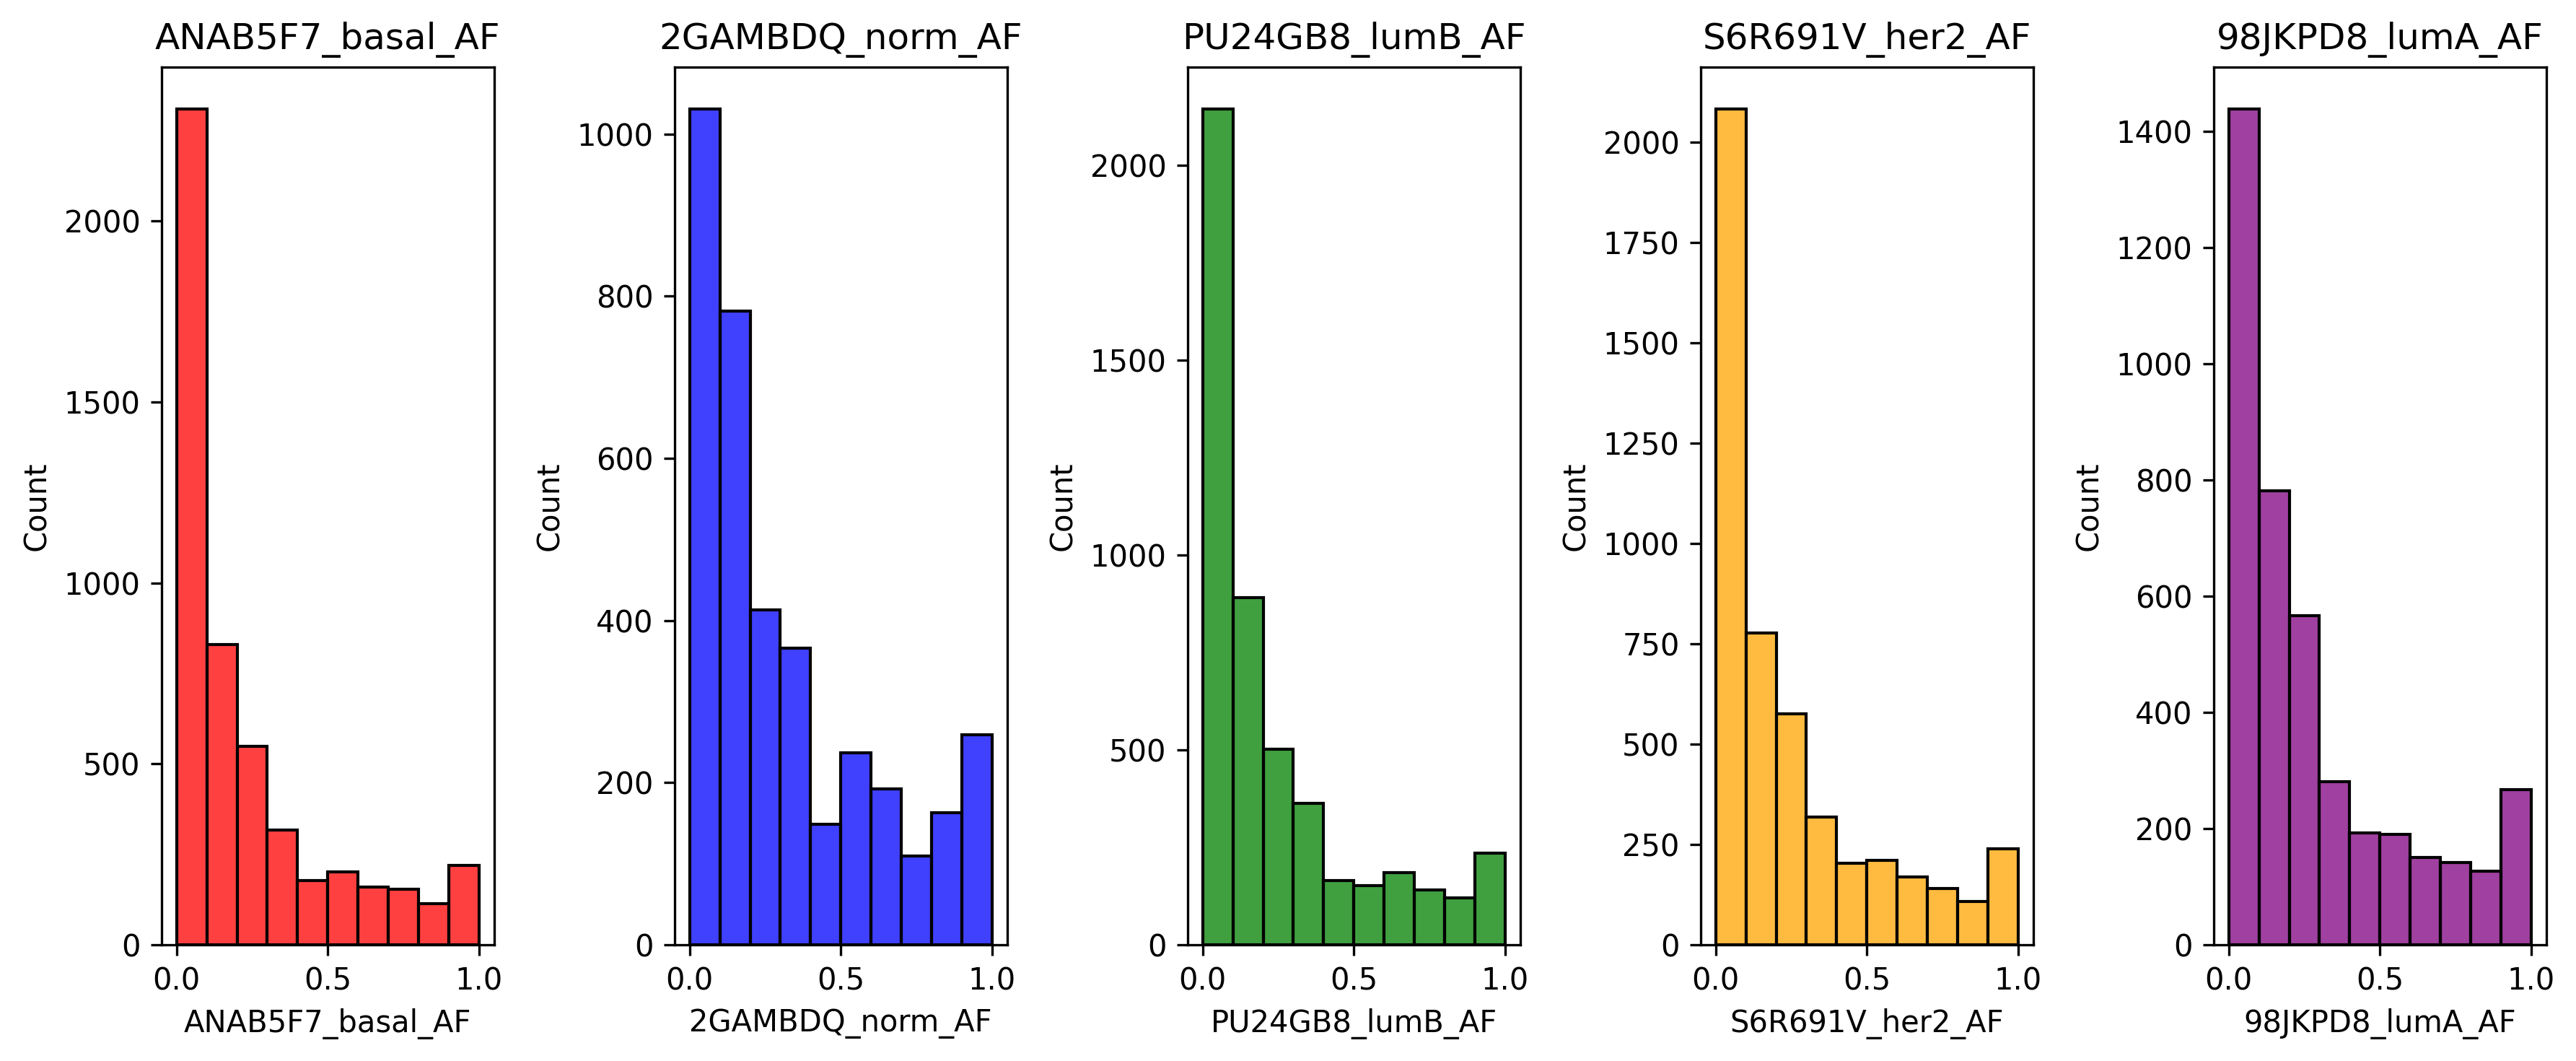

In [40]:
fig, axs = plt.subplots(1, 5, figsize=(12,5), dpi=300)

# Define a list of colors for the histograms
colors = ['red', 'blue', 'green', 'orange', 'purple']

sns.histplot(data=af_df_nonzero['ANAB5F7_basal_AF'], bins=np.linspace(0,1,11), ax=axs[0], color=colors[0])
sns.histplot(data=af_df_nonzero['2GAMBDQ_norm_AF'], bins=np.linspace(0,1,11), ax=axs[1], color=colors[1])
sns.histplot(data=af_df_nonzero['PU24GB8_lumB_AF'], bins=np.linspace(0,1,11), ax=axs[2], color=colors[2])
sns.histplot(data=af_df_nonzero['S6R691V_her2_AF'], bins=np.linspace(0,1,11), ax=axs[3], color=colors[3])
sns.histplot(data=af_df_nonzero['98JKPD8_lumA_AF'], bins=np.linspace(0,1,11), ax=axs[4], color=colors[4])

# Set titles for each subplot
axs[0].set_title('ANAB5F7_basal_AF')
axs[1].set_title('2GAMBDQ_norm_AF')
axs[2].set_title('PU24GB8_lumB_AF')
axs[3].set_title('S6R691V_her2_AF')
axs[4].set_title('98JKPD8_lumA_AF')

# Adjust the layout and spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


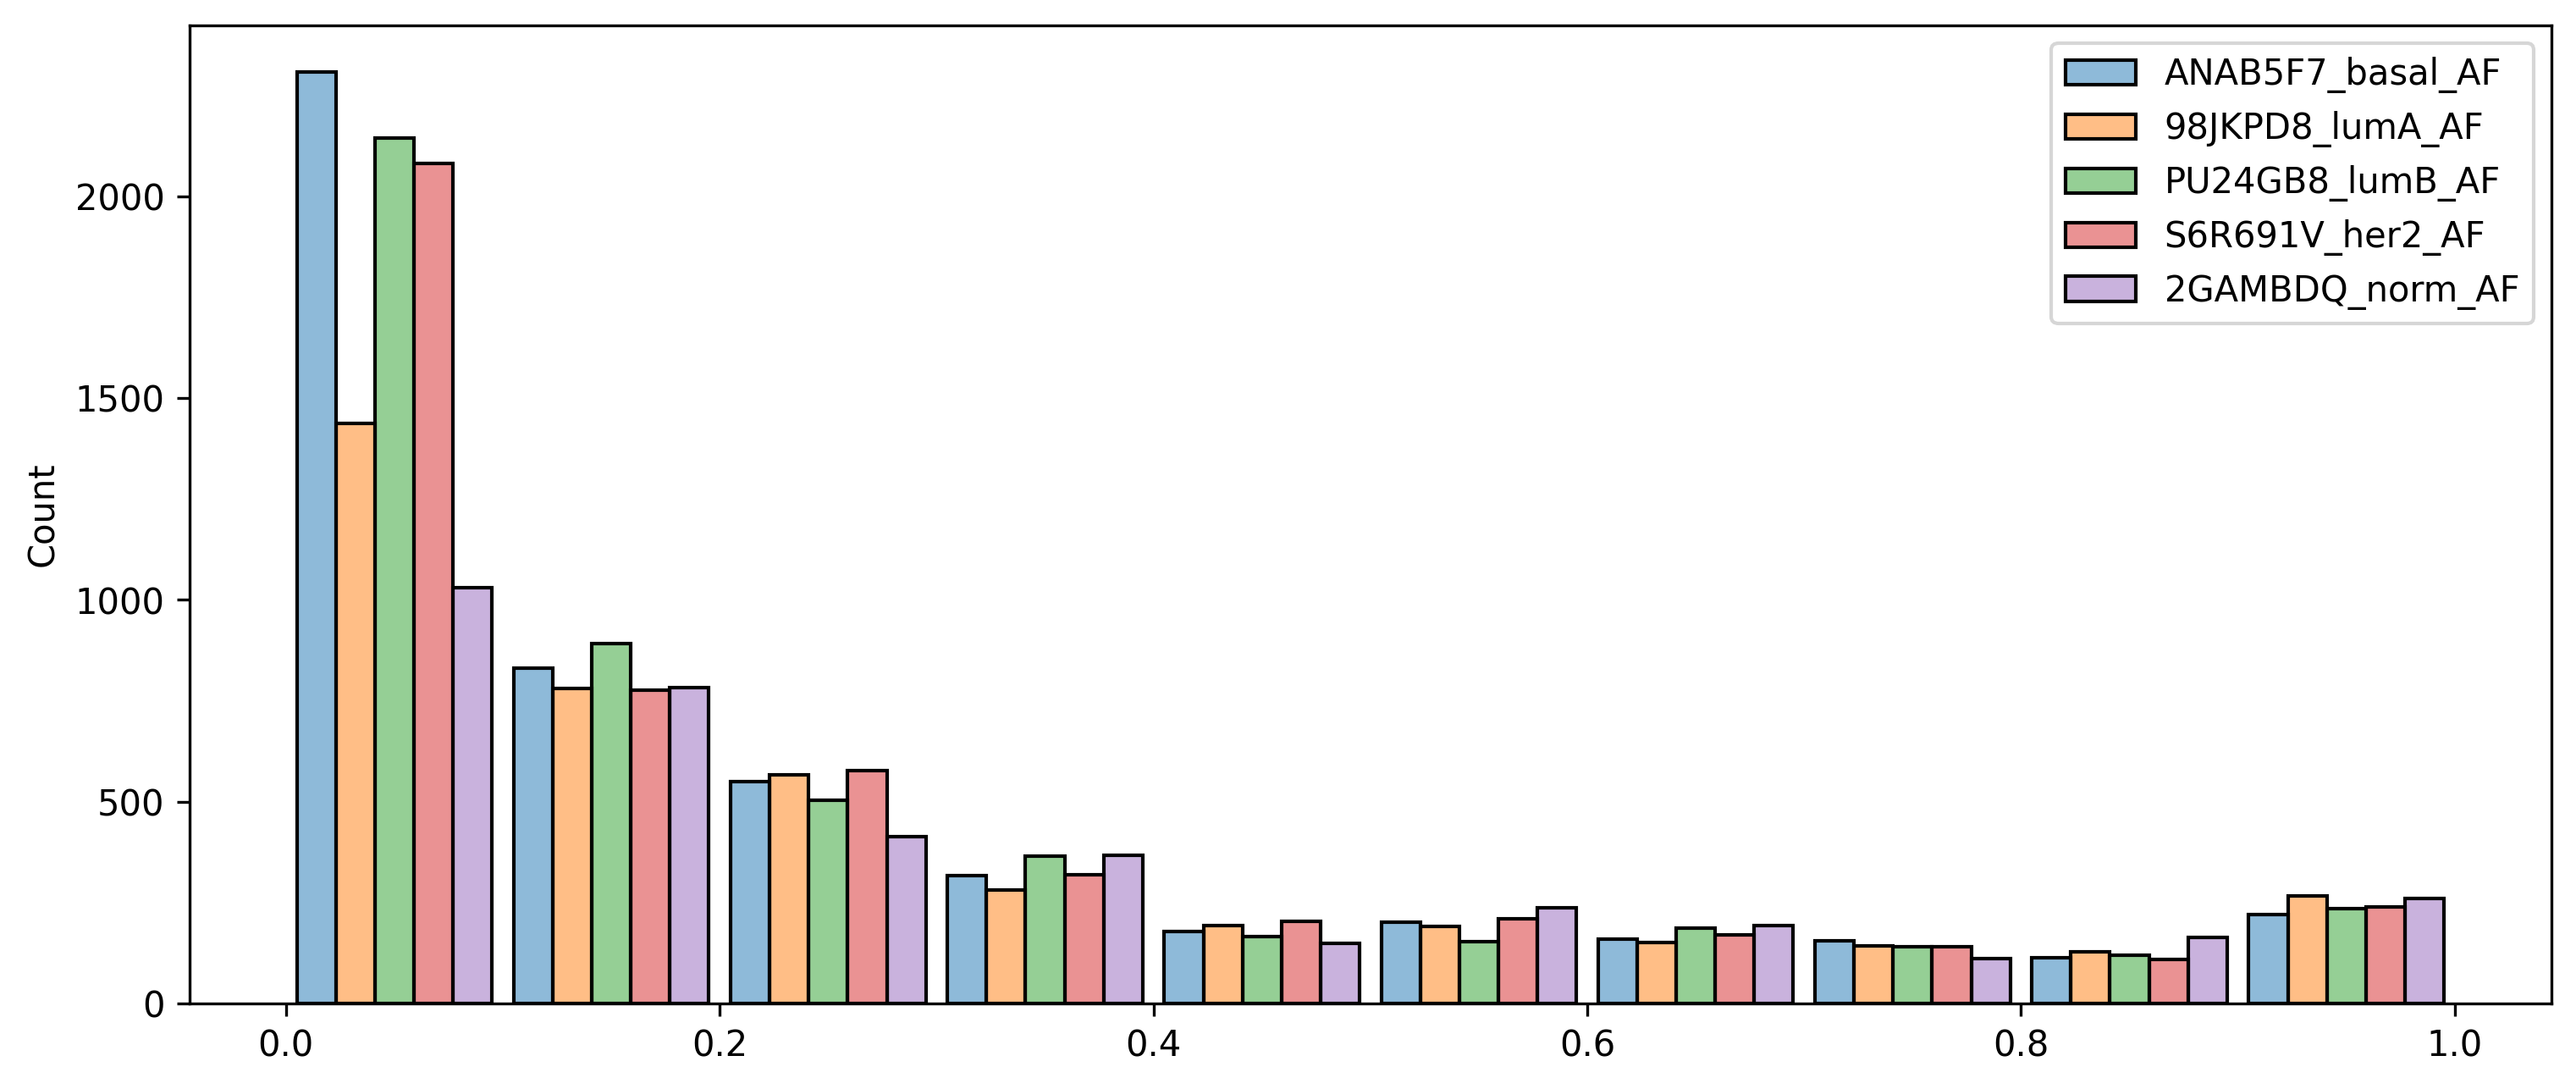

In [56]:
plt.figure(figsize=(12,5), dpi=300)

sns.histplot(data=af_df_nonzero, bins=np.linspace(0,1,11), alpha=0.5, multiple='dodge', shrink=0.9, binrange=(0,1))

# Show the plot
plt.show()

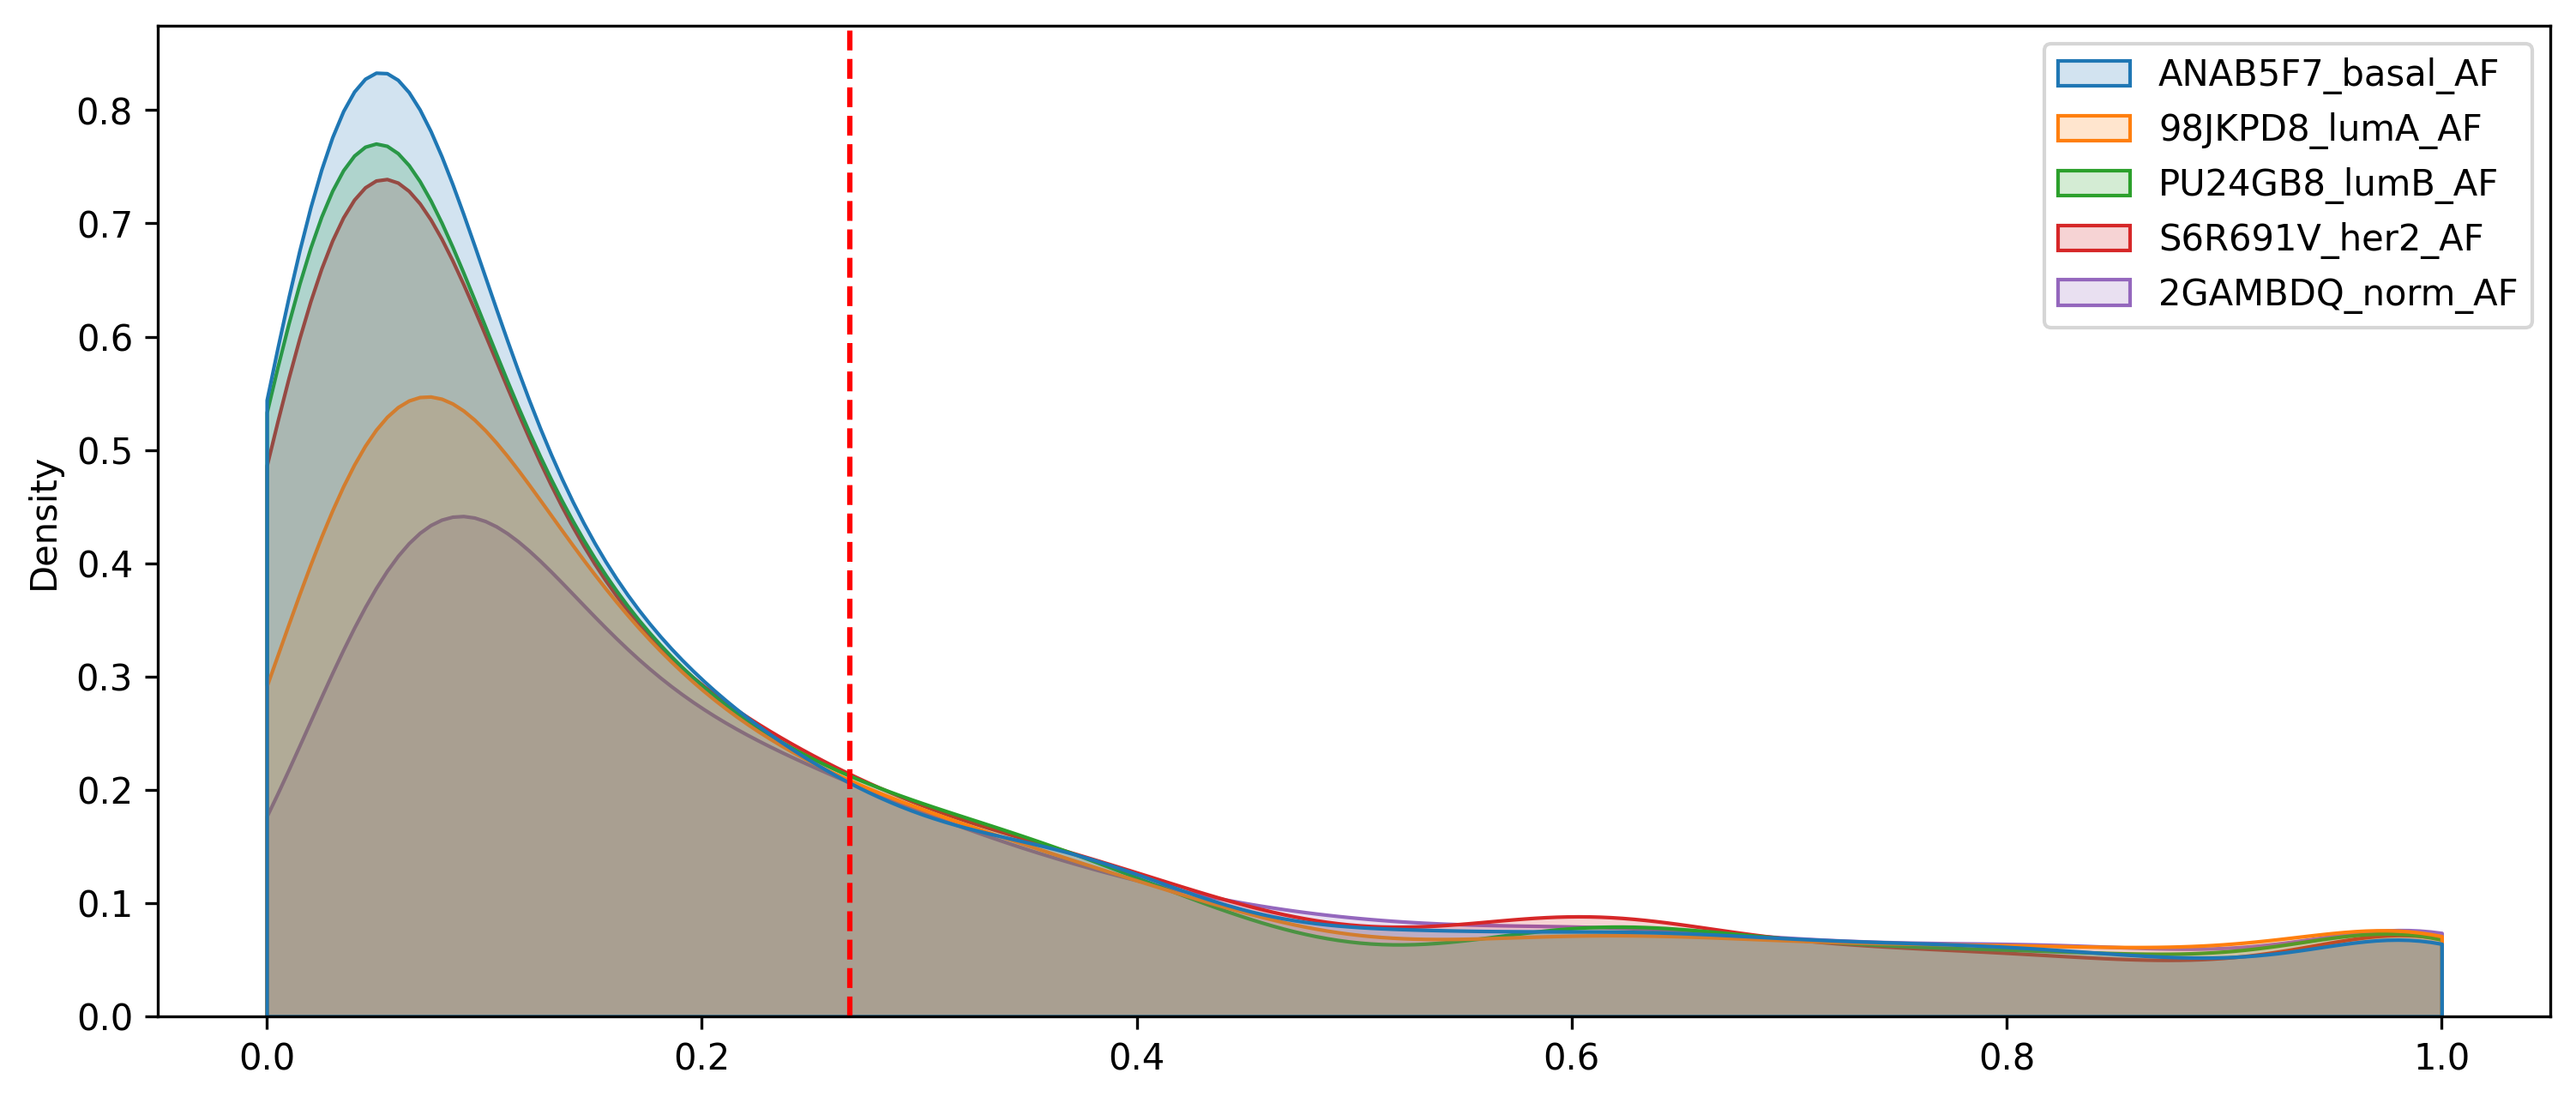

In [64]:
# filter out zero values
plt.figure(figsize=(12,5), dpi=300)
sns.kdeplot(data=af_df_nonzero, fill=True, clip=(0,1), alpha=0.2)
# draw a line at the mean of the means of the datasets
# Calculate the mean of the means of the datasets
mean_of_means = af_df_nonzero.mean(axis=0).mean()

# Draw a vertical line at the mean of the means
plt.axvline(x=mean_of_means, color='red', linestyle='--')

# Show the plot
plt.show()

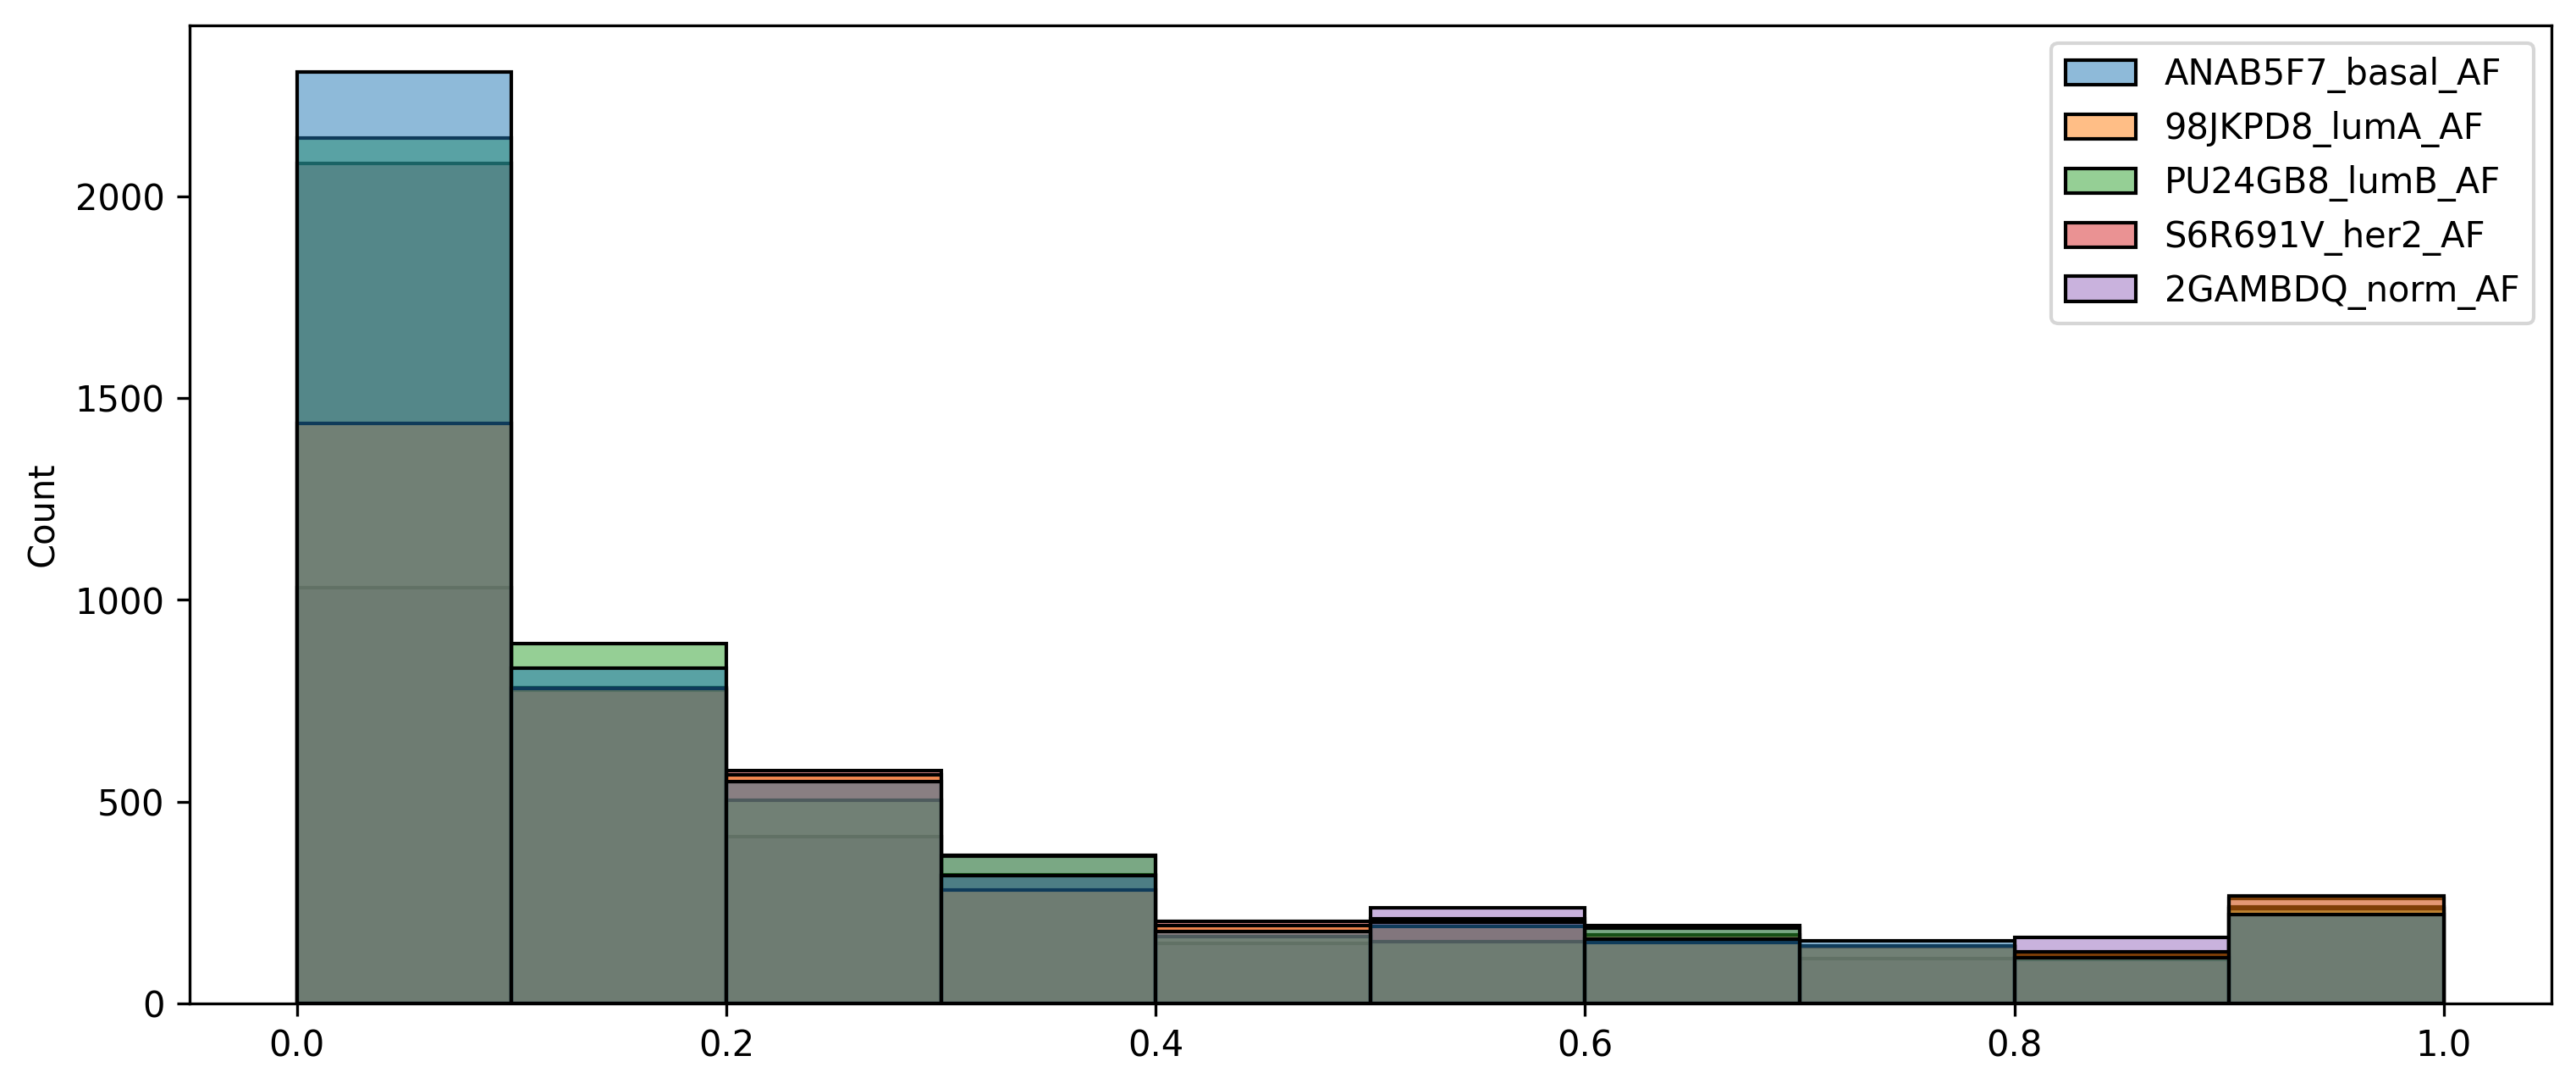

In [97]:
plt.figure(figsize=(12,5), dpi=300)

# for index, dataset in enumerate(af_df_nonzero.columns):
#     print(index+1, dataset)

#     sns.histplot(data=af_df_nonzero[dataset], bins=np.linspace(0,1,11))
    # order = np.argsort(np.argsort([b.get_height() for b in bars]))

ax = sns.histplot(data=af_df_nonzero, bins=np.linspace(0,1,11))




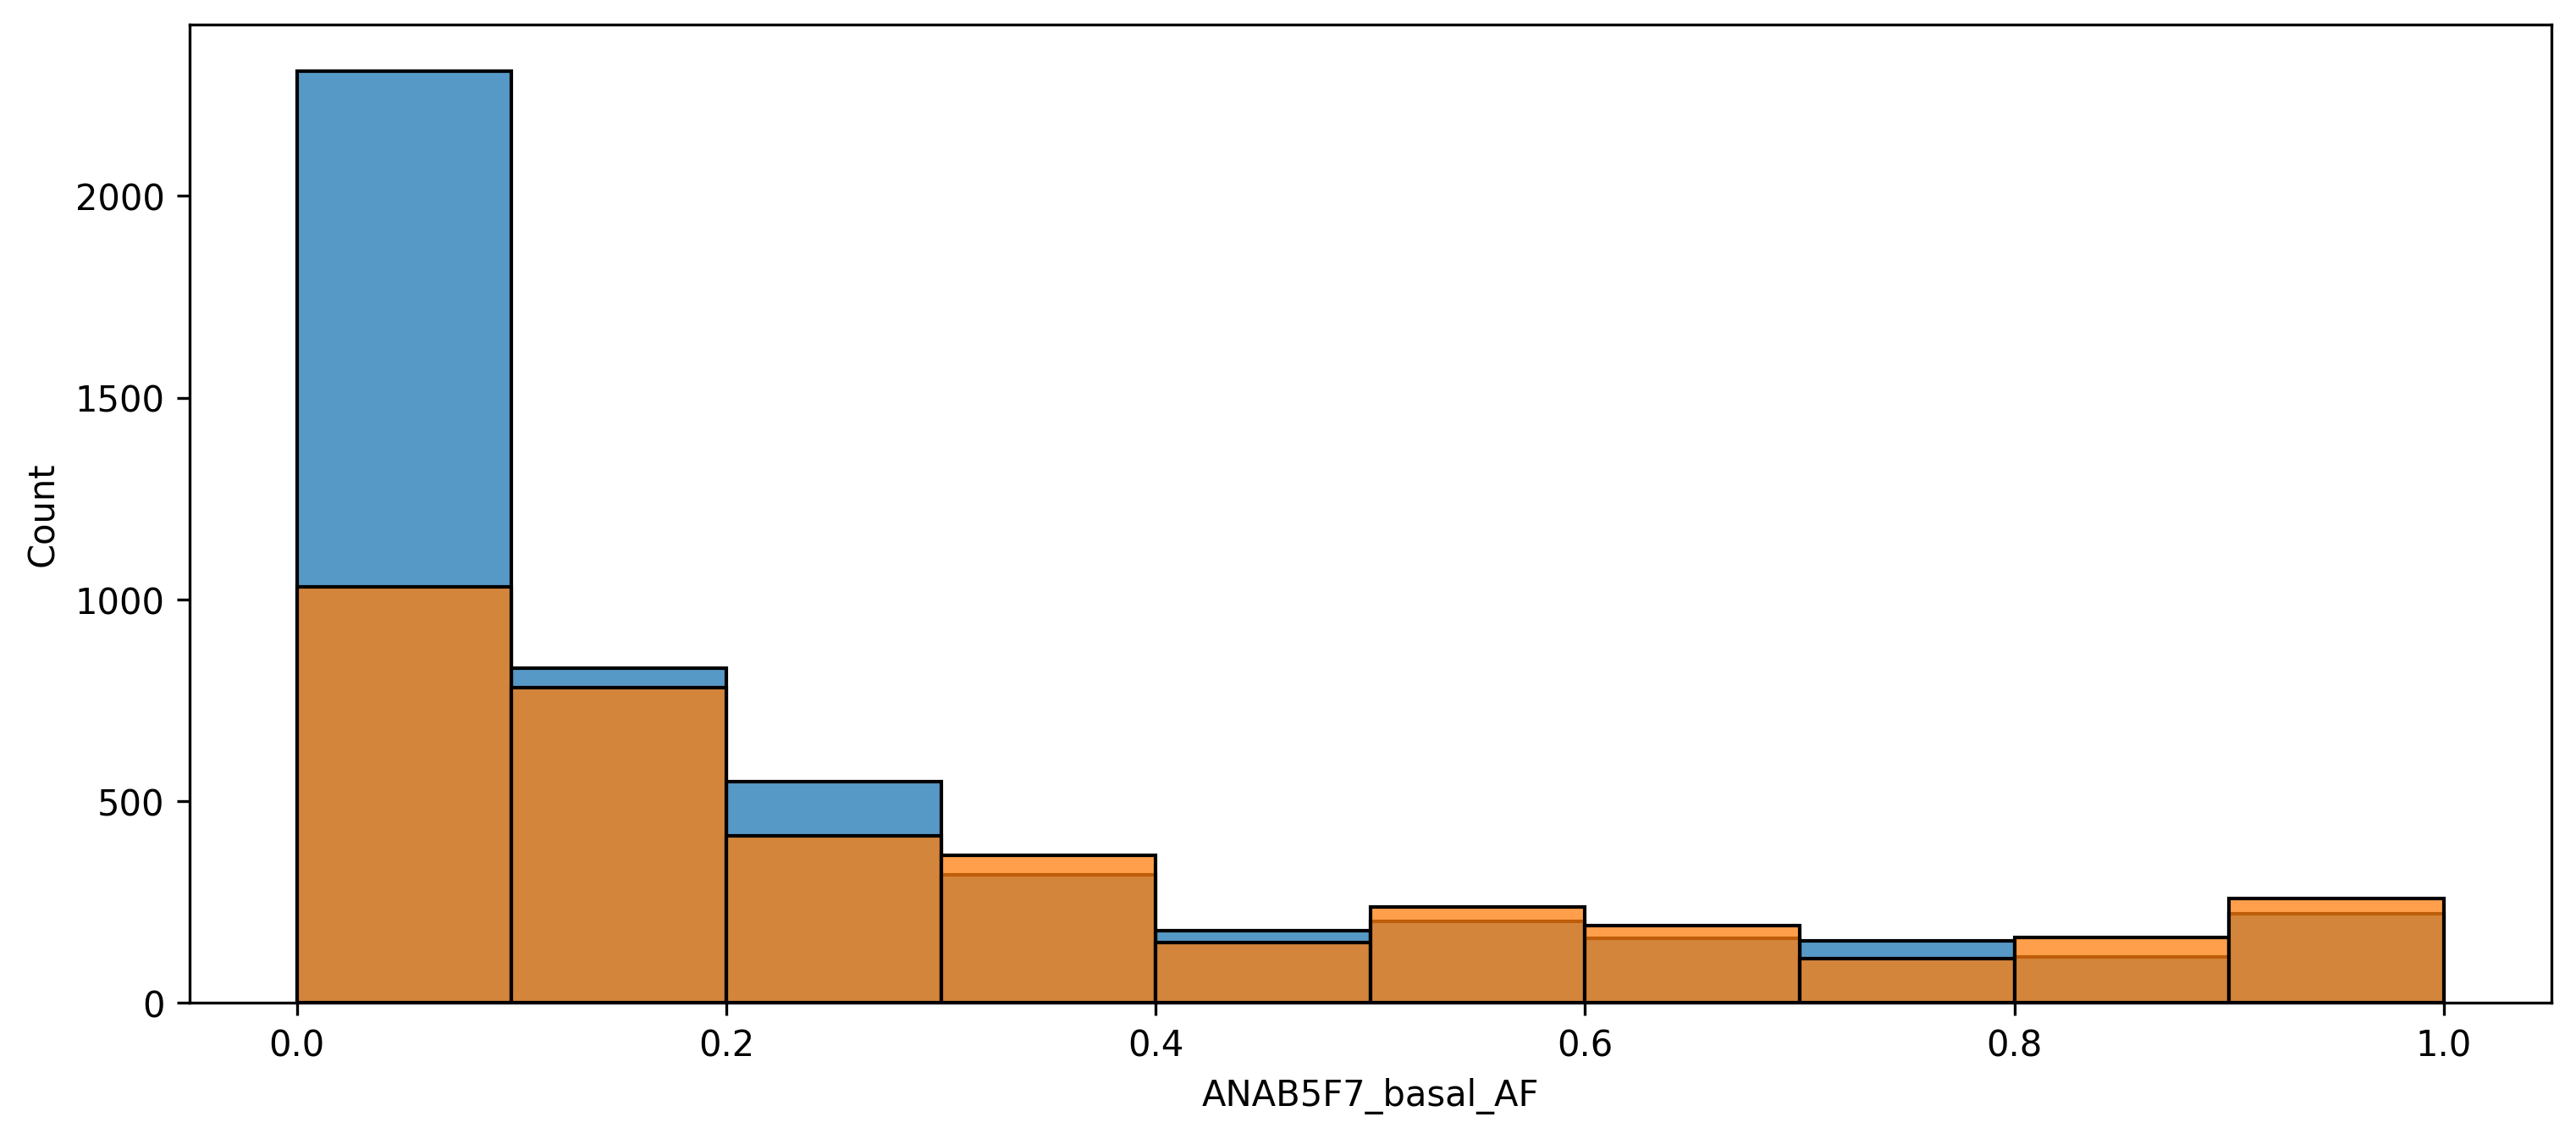

In [89]:


sns.histplot(data=af_df_nonzero['ANAB5F7_basal_AF'], bins=np.linspace(0,1,11), )
sns.histplot(data=af_df_nonzero['2GAMBDQ_norm_AF'], bins=np.linspace(0,1,11))

# Show the plot
plt.show()

In [ ]:
# import bioframe as bf

# # overlap fpscore combined matrix with Basal vcf data
# overlap_df = bf.overlap(df_fpscore, df_vcf_basal, suffixes=["","_ANAB5F7_Basal_varsite"], how='left')

# # drop these columns
# drop_patterns = ["ref_allele_", "alt_allele_", "chrom_", "end_"]
# for pat in drop_patterns:
#     overlap_df = overlap_df.drop(columns=overlap_df.filter(like=pat, axis=1).columns)
# # rename these columns
# overlap_df = overlap_df.rename(columns=lambda x: x.replace('start_', 'pos_') if x.startswith('start_') else x)

# # overlap the resulting dataframe again with lumA vcf data
# overlap_df = bf.overlap(overlap_df, df_vcf_lumA, suffixes=["","_98JKPD8_LumA_varsite"], how='left')

# # drop these columns
# for pat in drop_patterns:
#     overlap_df = overlap_df.drop(columns=overlap_df.filter(like=pat, axis=1).columns)
# # rename these columns
# overlap_df = overlap_df.rename(columns=lambda x: x.replace('start_', 'pos_') if x.startswith('start_') else x)

# # overlap again with lumB vcf data
# overlap_df = bf.overlap(overlap_df, df_vcf_lumB, suffixes=["","_PU24GB8_LumB_varsite"], how='left')

# # drop these columns
# for pat in drop_patterns:
#     overlap_df = overlap_df.drop(columns=overlap_df.filter(like=pat, axis=1).columns)
# # rename these columns
# overlap_df = overlap_df.rename(columns=lambda x: x.replace('start_', 'pos_') if x.startswith('start_') else x)

# # overlap again with her2 vcf data
# overlap_df = bf.overlap(overlap_df, df_vcf_her2, suffixes=["","_S6R691V_Her2_varsite"], how='left')

# # drop these columns
# for pat in drop_patterns:
#     overlap_df = overlap_df.drop(columns=overlap_df.filter(like=pat, axis=1).columns)
# # rename these columns
# overlap_df = overlap_df.rename(columns=lambda x: x.replace('start_', 'pos_') if x.startswith('start_') else x)

# # overlap again with normal-like vcf data
# overlap_df = bf.overlap(overlap_df, df_vcf_norm, suffixes=["","_2GAMBDQ_Norm_varsite"], how='left')

# # drop these columns
# for pat in drop_patterns:
#     overlap_df = overlap_df.drop(columns=overlap_df.filter(like=pat, axis=1).columns)
# # rename these columns
# overlap_df = overlap_df.rename(columns=lambda x: x.replace('start_', 'pos_') if x.startswith('start_') else x)

# # save the dataframe to a file
# overlap_df.to_csv('/home/users/ntu/suffiazi/scripts/gatk-workflow-scripts/polars_processing/combined_fps-variant-freq.tsv', sep='\t', index=False)

# overlap_df.head(n=15)

In [ ]:
# show only row number 100 and 101
# overlap_df.iloc[[99, 100]]